In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Prepare data

In [3]:
reload(util.training)

<module 'util.training' from '/home/jovyan/ForestLST/util/training.py'>

In [4]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")\
    .to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'vod' (time: 27, band: 11, y: 652, x: 590)> Size: 457MB
array([[[[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         ...,
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,        nan,
                 nan,        nan]],

        [[ 2.450e+02,  4.470e+02,  6.650e+02, ...,  6.870e+02,
           6.760e+02,  6.570e+02],
         [ 2.300e+02,  4.660e+02,  6.720e+02, ...,  6.860e+02,
           6.690e+02,  6.550e+02],
         [ 3.980e+02,  4.080e+02,  5.540e+02, ...,  6.720e+02,
           6.620e+02,  6.500e+02],
...
         [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.000e+00,
           1.000e+00,  1.000e+00],
         [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.000e+00,
           1.000e+00,  1.000e+00],
         [ 0.000e+00,  0.000e+00,  0.000e+00, ...,  1.000e+00,
           1.000e+00,  1.000e+00]],

        [[       nan,        nan,        nan, ...,        nan,
                 nan,        nan],
         [       nan,        nan,        nan, ...,  0.000e+00,
           0.000e+00,  0.000e+00],
         [       nan,        nan,        nan, ...,  0.000e+00,
           0.000e+00,  0.000e+00],
         ...,
         [       nan,        nan,        nan, ...,  0.000e+00,
           0.000e+00,  0.000e+00],
         [       nan,        nan,        nan, ...,  0.000e+00,
           0.000e+00,  0.000e+00],
         [       nan,        nan,        nan, ...,  0.000e+00,
           0.000e+00,  0.000e+00]]]], dtype=float32)
Coordinates:
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * band      (band) object 88B MultiIndex
  * variable  (band) <U9 396B 'vod' 'elev' 'slope' ... 'vp' 'tmin' 'treecover'

Make sure windowing works right

In [5]:
window = dict(x=[8, False], y=[8, False], time=[5, False])
mort_arr = ds.sel(band="mortality", drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr)

In [6]:
len(mort_ds)

555757

In [7]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band="mortality")

Set up model definition

In [8]:
from util.convlstm import DamageConvLSTM

input_vars = [5, 6, 7] # fire, mort, prcp
input_channel = len(input_vars)
hidden_dim = 16
num_layers = 3
kernel = (3, 3)

m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True) 

Verify that the shapes work out.

In [9]:
fake_input = torch.tensor(window_x.isel(band=input_vars).values).unsqueeze(0).to(torch.float32)
fake_output = m(fake_input)
assert fake_output.shape == window_y.shape

Data pipeline

In [10]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.time.values
train_years = np.concatenate((years[:5], years[10:15]))
valid_years = years[5:10]
test_years  = years[15:20]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [1997 1998 1999 2000 2001 2007 2008 2009 2010 2011]
Validation years: [2002 2003 2004 2005 2006]
Testing years: [2012 2013 2014 2015 2016]


In [11]:
# N.b. we could boost the number of samples by allowing up to 20% NA in each window and then
# replacing these values with zero in the dataloader.
valid_wds = util.datasets.WindowXarrayDataset(ds.sel(time=valid_years), window, mask=mort_arr.sel(time=valid_years))
test_wds  = util.datasets.WindowXarrayDataset(ds.sel(time= test_years), window, mask=mort_arr.sel(time= test_years))

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 28019
Testing: 34174


In [12]:
from torch.utils.data import DataLoader

target = "mortality"
target_ind = 6 # in the band coordinate

dtype = torch.float32

def collator(patch_list):
    X = torch.stack([
        torch.tensor(
            np.squeeze(patch.values[:-1, input_vars, :, :]),
            dtype=dtype
        )
        for patch in patch_list
    ])

    # Replace nan cells with the channel mean from this batch
    ch_mean = torch.nanmean(X, dim=0)
    X += ch_mean * torch.isnan(X)
    
    y = torch.stack([
        torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype)/100
        for patch in patch_list
    ]).squeeze(dim=2)

    return X, y

batch_size = 32

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(valid_wds, batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))
test_loader  = DataLoader(test_wds , batch_size, shuffle=True, collate_fn=collator, generator=torch.Generator(device=device))

In [13]:
# Again make sure the sizes work out
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)
assert out.shape == y.shape

torch.Size([32, 4, 3, 8, 8])
torch.Size([32, 8, 8])


Resampling the training dataset. We want to reduce the proportion of examples with near-zero mortality in the training dataset. But undersampling the majority classes will result in fewer overall samples. Let's calculate the effect.

In [14]:
thetas = np.arange(0, 1, step=0.1)
ns = []

train_ds = ds.sel(time=train_years)

for th in thetas:
    ns.append(
        len(util.datasets.ResampleXarrayDataset(
            train_ds, window, mask=mort_arr.sel(time=train_years),
            theta=th, n_bins=5
        ))
    )

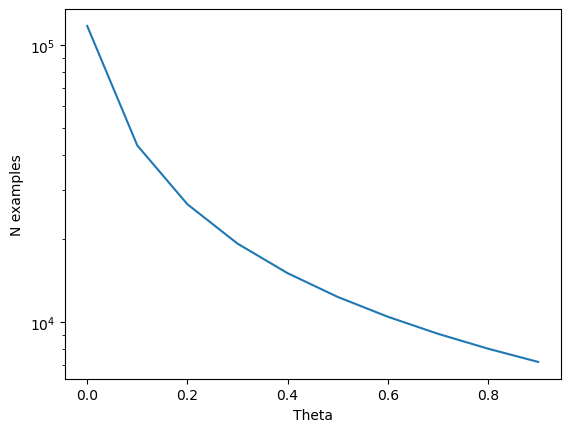

In [15]:
plt.plot(thetas, ns)
plt.xlabel("Theta")
plt.ylabel("N examples")
plt.yscale("log")
plt.show()

In [16]:
theta_max = 0.5 # somewhat arbitrary

Training loop. Note this takes like 12 hours to train all the models.

Calculate performance on test set

In [17]:
import torchmetrics
from util.training import ReduceLRTrainer

input_vars = [5, 6, 7] # fire, mort, prcp
input_channel = len(input_vars)
hidden_dim = 16
num_layers = 3
kernel = (3, 3)

def reload_model(path):
    m = DamageConvLSTM(input_channel, hidden_dim, kernel, num_layers, batch_first=True)
    m.load_state_dict(torch.load(path, weights_only=True))
    return m

# Test
m = reload_model("logs/convlstm__8_8_5__mort_fire_ppt__theta0.00/model.pth")

In [18]:
import glob
models_to_eval = glob.glob("logs/convlstm*theta*/model.pth")
print("\n".join(models_to_eval))

logs/convlstm__8_8_5__mort_fire_ppt__theta0.00/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.06/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.11/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.17/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.22/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.28/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.33/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.39/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.44/model.pth
logs/convlstm__8_8_5__mort_fire_ppt__theta0.50/model.pth


In [19]:
from tqdm import tqdm
import pandas as pd

metrics = []

for model in models_to_eval:
    m = reload_model(model)

    r2  = torchmetrics.regression.ExplainedVariance()
    nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError()
    mse = torchmetrics.regression.MeanSquaredError()
    
    m.eval()
    with torch.no_grad():
        for (X, y) in tqdm(test_loader, leave=False):
            y_hat = m(X)
            r2(y_hat, y)
            mse(y_hat, y)
            nrmse(y_hat, y)

    r2_val = r2.compute()
    mse_val = mse.compute()
    nrmse_val = nrmse.compute()
    
    print(model)
    print("R2:", r2_val)
    print("MSE:", mse_val)
    print("NRMSE:", nrmse_val)

    metrics.append(
        [model,
         nrmse_val,
         r2_val,
         mse_val]
    )
    

logs/convlstm__8_8_5__mort_fire_ppt__theta0.00/model.pth
R2: tensor(0.2303)
MSE: tensor(0.0132)
NRMSE: tensor(3.0390)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.06/model.pth
R2: tensor(0.1633)
MSE: tensor(0.0144)
NRMSE: tensor(3.1653)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.11/model.pth
R2: tensor(0.1590)
MSE: tensor(0.0144)
NRMSE: tensor(3.1728)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.17/model.pth
R2: tensor(0.1642)
MSE: tensor(0.0144)
NRMSE: tensor(3.1670)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.22/model.pth
R2: tensor(0.1963)
MSE: tensor(0.0139)
NRMSE: tensor(3.1102)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.28/model.pth
R2: tensor(0.1829)
MSE: tensor(0.0141)
NRMSE: tensor(3.1353)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.33/model.pth
R2: tensor(0.1977)
MSE: tensor(0.0138)
NRMSE: tensor(3.1004)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.39/model.pth
R2: tensor(0.1907)
MSE: tensor(0.0139)
NRMSE: tensor(3.1174)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.44/model.pth
R2: tensor(0.1996)
MSE: tensor(0.0138)
NRMSE: tensor(3.1077)


logs/convlstm__8_8_5__mort_fire_ppt__theta0.50/model.pth
R2: tensor(0.1555)
MSE: tensor(0.0146)
NRMSE: tensor(3.1958)


Learning curves

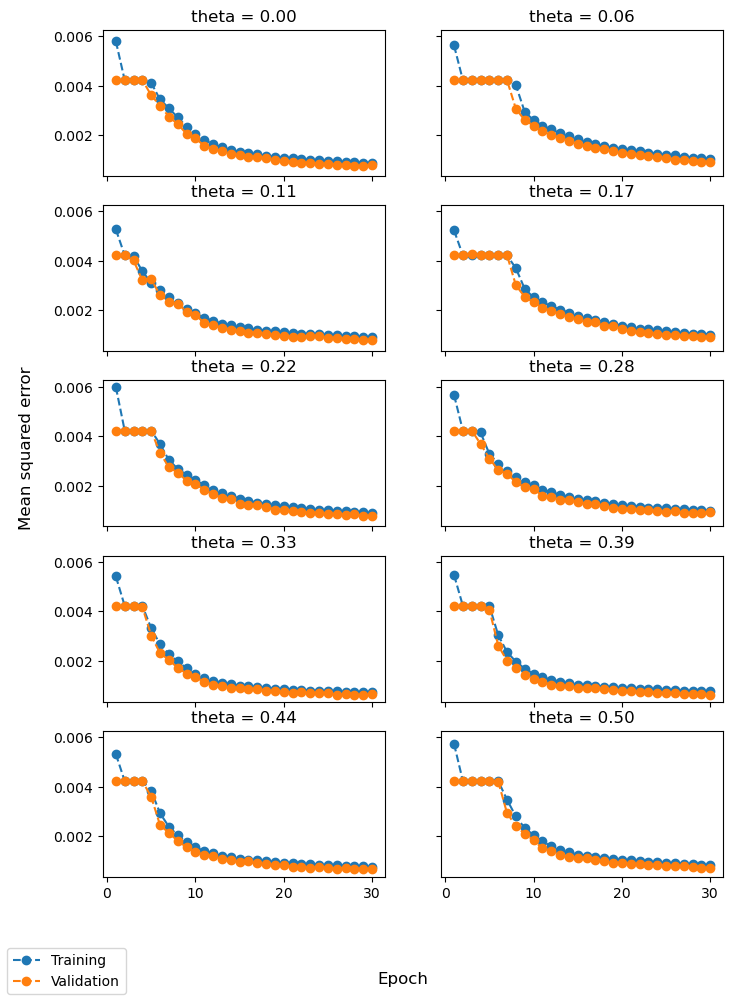

In [20]:
fig, axes = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(8, 11))

for (ax, model) in zip(axes.flatten(), models_to_eval):
    theta_idx = model.find("theta")+5
    theta_val = model[theta_idx:theta_idx+4]
    
    model_stats = util.training.parse_tensorboard(
        model.replace("model.pth", "history/"),
        ["Loss/train", "Loss/valid"]
    )
    
    train_loss = model_stats["Loss/train"]["value"]
    valid_loss = model_stats["Loss/valid"]["value"]
    epochs = np.arange(1, train_loss.shape[0]+1, step=1)
    
    ax.plot(epochs, train_loss, label="Training", linestyle='--', marker='o')
    ax.plot(epochs, valid_loss, label="Validation", linestyle='--', marker='o')
    ax.set_title("theta = " + theta_val)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')

fig.supxlabel("Epoch")
fig.supylabel("Mean squared error")
plt.show()

Final performance for MSE, NRMSE, and R2 across all thetas.

In [21]:
metrics_df = pd.DataFrame(metrics, columns=["Model", "test_nrmse", "test_r2", "test_mse"])

train_nrmse = []
valid_nrmse = []
train_r2 = []
valid_r2 = []
train_loss = []
valid_loss = []


for model in models_to_eval:
    stats = util.training.parse_tensorboard(
        model.replace("model.pth", "history/"),
        [
             "NormalizedRootMeanSquaredError()/train", "NormalizedRootMeanSquaredError()/valid",
             "ExplainedVariance()/train", "ExplainedVariance()/valid",
             "Loss/train", "Loss/valid"
        ]
    )

    train_nrmse.append(stats["NormalizedRootMeanSquaredError()/train"]["value"].iloc[-1])
    valid_nrmse.append(stats["NormalizedRootMeanSquaredError()/valid"]["value"].iloc[-1])
    train_r2.append(stats["ExplainedVariance()/train"]["value"].iloc[-1])
    valid_r2.append(stats["ExplainedVariance()/valid"]["value"].iloc[-1])
    train_loss.append(stats["Loss/train"]["value"].iloc[-1])
    valid_loss.append(stats["Loss/train"]["value"].iloc[-1])

metrics_df["train_nrmse"] = train_nrmse
metrics_df["valid_nrmse"] = valid_nrmse
metrics_df["train_r2"] = train_r2
metrics_df["valid_r2"] = valid_r2
metrics_df["train_loss"] = train_loss
metrics_df["valid_loss"] = valid_loss

In [25]:
def extract_theta(name):
    theta_idx = name.find("theta")+5
    theta_val = float(name[theta_idx:theta_idx+4])
    return theta_val

metrics_df["theta"] = metrics_df["Model"].map(extract_theta)

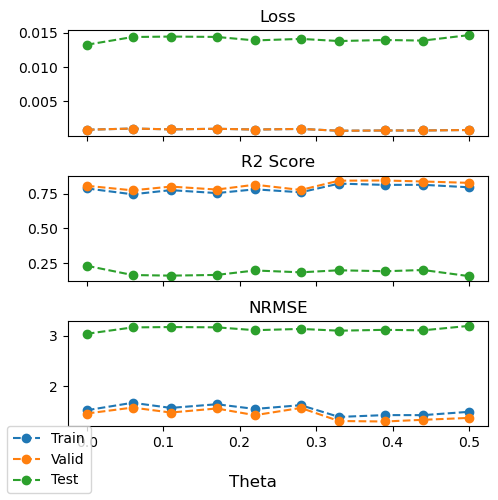

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(5, 5))

style = dict(linestyle='--', marker='o')

ax1.plot(metrics_df["theta"], metrics_df["train_loss"], label="Train", **style)
ax1.plot(metrics_df["theta"], metrics_df["valid_loss"], label="Valid", **style)
ax1.plot(metrics_df["theta"], metrics_df["test_mse"], label="Test", **style)
ax1.set_title("Loss")

ax2.plot(metrics_df["theta"], metrics_df["train_r2"], label="Train", **style)
ax2.plot(metrics_df["theta"], metrics_df["valid_r2"], label="Valid", **style)
ax2.plot(metrics_df["theta"], metrics_df["test_r2"], label="Test", **style)
ax2.set_title("R2 Score")

ax3.plot(metrics_df["theta"], metrics_df["train_nrmse"], label="Train", **style)
ax3.plot(metrics_df["theta"], metrics_df["valid_nrmse"], label="Valid", **style)
ax3.plot(metrics_df["theta"], metrics_df["test_nrmse"], label="Test", **style)
ax3.set_title("NRMSE")


handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower left')

fig.supxlabel("Theta")

fig.tight_layout()

plt.show()